In [88]:
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import torch
from transformers import *

# ***Reading the Dataset***

In [89]:
data = pd.read_csv("./data/IMDB_Dataset.csv")
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


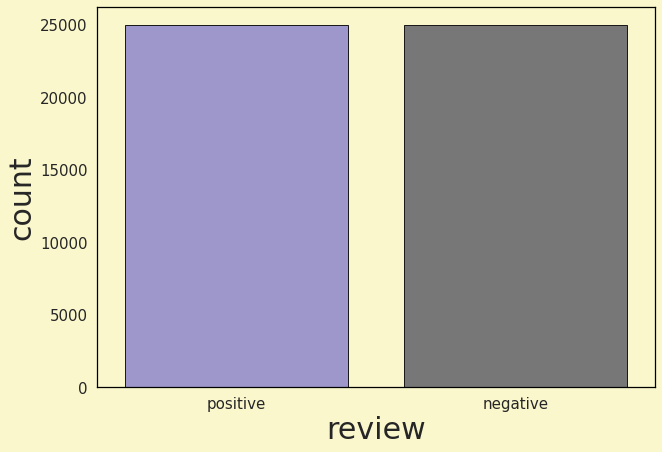

In [90]:
fig, axes = plt.subplots(nrows = 1, ncols =1, figsize = (10, 7),facecolor='#FAF7CC')
sns.set(rc={'axes.facecolor':'#FAF7CC',"axes.edgecolor":"black","axes.grid":False,"axes.labelsize":30,"xtick.labelsize":15,"ytick.labelsize":15})
sns.countplot(x="sentiment",data=data,palette=["#988ed5", "#777777"],edgecolor="k")
plt.xlabel('review')
plt.show()

# ***Data Preprocessing***

In [91]:
data['sentiment'] = data['sentiment'].apply(lambda x: 1 if x=='positive' else 0)

#### Importing BERT pretrained model tokenizer :

In [92]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [93]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading: 100%|██████████| 213k/213k [00:00<00:00, 932kB/s] 
Downloading: 100%|██████████| 29.0/29.0 [00:00<00:00, 19.9kB/s]
Downloading: 100%|██████████| 436k/436k [00:00<00:00, 1.06MB/s]


#### Special tokens:

marker for ending of a sentence :

In [94]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

classification token at the start of each sentence, so BERT knows we're doing classification

In [95]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

padding token :

In [96]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

unkown token :

In [97]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

#### Precising the max length for BERT tokenizer :
In order to get the suitable max sequence length we need to take a look at all reviews length and then select the most appropriate one


In [118]:
def token_len(review):
    return(len(tokenizer.encode(review, max_length=512,truncation=False)))

In [119]:
data_length=data['review'].apply(token_len)

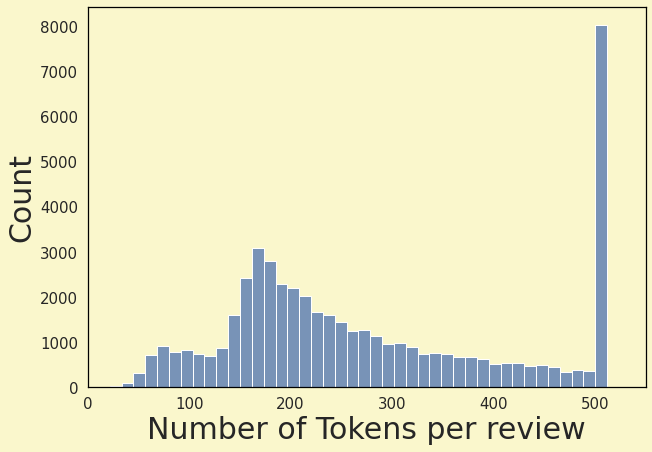

In [129]:
fig, axes = plt.subplots(nrows = 1, ncols =1, figsize = (10, 7),facecolor='#FAF7CC')
sns.histplot(data_length)
plt.xlim([0, 550]);
plt.xlabel('Number of Tokens per review');

#### We will set MAX_LENGTH to 256

In [131]:
MAX_LEN = 256      #for not consuming much resources
RANDOM_SEED = 40
device = torch.device( 'cuda' )

In [132]:
from sklearn.model_selection import train_test_split
#doing the split of the dataset into training, validation and testing sets
data_train, data_test = train_test_split(data, test_size=0.1, random_state=RANDOM_SEED)
data_val, data_test = train_test_split(data_test, test_size=0.5, random_state=RANDOM_SEED)

In [133]:
data_train.shape, data_val.shape, data_test.shape

((45000, 2), (2500, 2), (2500, 2))

# Creating Dataset and Dataloader using `torch.utils.data`

In [134]:
from torch.utils.data import Dataset, DataLoader

class IMDBDataset(Dataset):

  def __init__(self, reviews, sentiments, tokenizer, max_len):
    self.reviews = reviews
    self.sentiments = sentiments
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    sentiment = self.sentiments[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'sentiments': torch.tensor(sentiment, dtype=torch.long)
    }

In [135]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = IMDBDataset(
    reviews=df.review.to_numpy(),
    sentiments=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

BERT authors recommendations for fine-tuning :

    * Batch size: 16, 32
    * Learning rate (Adam): 5e-5, 3e-5, 2e-5
    * Number of epochs: 2, 3, 4

We’re going to ignore the number of epochs recommendation but stick with the rest. Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.